In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0-dev20210819


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
'''vamos executar o código da rede neural, mas ajustando a taxa de aprendizagem por 
época em a fim de encontrar o melhor para o treinamento completo. Vamos traçar os 
resultados para tentar encontre a taxa de aprendizagem ideal.'''
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/bene/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 2s 52ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.3787 - mae: 185.8787
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 12ms/step - loss: 19.8700 - mae: 20.3648
Epoch 88/100
8/8 [==============================] - 0s 10ms/step - loss: 20.6199 - mae: 21.1157
Epoch 89/100
8/8 [==============================] - 0s 10ms/step - loss: 23.3658 - mae: 23.8626
Epoch 90/100
8/8 [==============================] - 0s 12ms/step - loss: 28.7680 - mae: 29.2665
Epoch 91/100
8/8 [==============================] - 0s 9ms/step - loss: 30.8635 - mae: 31.3609
Epoch 92/100
8/8 [==============================] - 0s 10ms/step - loss: 34.0561 - mae: 34.5544
Epoch 93/100
8/8 [==============================] - 0s 10ms/step - loss: 23.0374 - mae: 23.5338
Epoch 94/100
8/8 [==============================] - 0s 11ms/step - loss: 21.6126 - mae: 22.1076
Epoch 95/100
8/8 [==============================] - 0s 11ms/step - loss: 49.4959 - mae: 49.9953
Epoch 96/100
8/8 [==============================] - 0s 10ms/step - loss: 76.9384 - mae: 77.4384
Epoch 97/100
8/8 [==============================] - 0s

[1e-08, 0.0001, 0, 30]

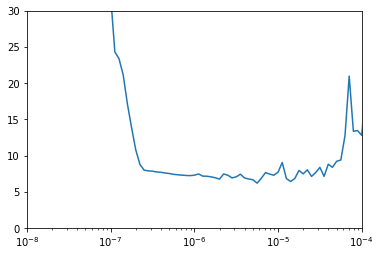

In [7]:
#Vamos traçar os resultados para tentar encontre a taxa de aprendizagem ideal.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

#Ajustou a taxa de aprendizagem de acordo com o grafico acima ou seja: lr=5e-5
optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#Escolheu 400 épocas para serem treinadas
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 15ms/step - loss: 117.2725 - mae: 117.7722
Epoch 2/400
8/8 [==============================] - 0s 13ms/step - loss: 44.0110 - mae: 44.5083
Epoch 3/400
8/8 [==============================] - 0s 12ms/step - loss: 22.3317 - mae: 22.8266
Epoch 4/400
8/8 [==============================] - 0s 11ms/step - loss: 12.9401 - mae: 13.4327
Epoch 5/400
8/8 [==============================] - 0s 11ms/step - loss: 10.2014 - mae: 10.6848
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 8.3283 - mae: 8.8151
Epoch 7/400
8/8 [==============================] - 0s 18ms/step - loss: 6.9704 - mae: 7.4522
Epoch 8/400
8/8 [==============================] - 0s 12ms/step - loss: 6.4044 - mae: 6.8822
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 6.0183 - mae: 6.4993
Epoch 10/400
8/8 [==============================] - 0s 11ms/step - loss: 5.8204 - mae: 6.2997
Epoch 11/400
8/8 [==============================] - 0s 16

8/8 [==============================] - 0s 11ms/step - loss: 4.8391 - mae: 5.3169
Epoch 89/400
8/8 [==============================] - 0s 26ms/step - loss: 4.6613 - mae: 5.1401
Epoch 90/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6066 - mae: 5.0839
Epoch 91/400
8/8 [==============================] - 0s 14ms/step - loss: 4.6879 - mae: 5.1634
Epoch 92/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6376 - mae: 5.1128
Epoch 93/400
8/8 [==============================] - 0s 13ms/step - loss: 4.7439 - mae: 5.2185
Epoch 94/400
8/8 [==============================] - 0s 12ms/step - loss: 4.8625 - mae: 5.3384
Epoch 95/400
8/8 [==============================] - 0s 19ms/step - loss: 5.0449 - mae: 5.5269
Epoch 96/400
8/8 [==============================] - 0s 13ms/step - loss: 4.6724 - mae: 5.1469
Epoch 97/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6699 - mae: 5.1480
Epoch 98/400
8/8 [==============================] - 0s 13ms/step - loss: 

8/8 [==============================] - 0s 11ms/step - loss: 4.4864 - mae: 4.9614
Epoch 175/400
8/8 [==============================] - 0s 11ms/step - loss: 4.6573 - mae: 5.1318
Epoch 176/400
8/8 [==============================] - 0s 10ms/step - loss: 4.5641 - mae: 5.0354
Epoch 177/400
8/8 [==============================] - 0s 12ms/step - loss: 4.9015 - mae: 5.3846
Epoch 178/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5145 - mae: 4.9850
Epoch 179/400
8/8 [==============================] - 0s 16ms/step - loss: 4.6695 - mae: 5.1418
Epoch 180/400
8/8 [==============================] - 0s 18ms/step - loss: 4.8716 - mae: 5.3489
Epoch 181/400
8/8 [==============================] - 0s 14ms/step - loss: 4.4217 - mae: 4.8981
Epoch 182/400
8/8 [==============================] - 0s 13ms/step - loss: 4.3900 - mae: 4.8678
Epoch 183/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4580 - mae: 4.9301
Epoch 184/400
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 4.4750 - mae: 4.9472
Epoch 261/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3236 - mae: 4.7937
Epoch 262/400
8/8 [==============================] - 0s 13ms/step - loss: 4.3057 - mae: 4.7767
Epoch 263/400
8/8 [==============================] - 0s 14ms/step - loss: 4.3370 - mae: 4.8094
Epoch 264/400
8/8 [==============================] - 0s 13ms/step - loss: 4.3358 - mae: 4.8075
Epoch 265/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3705 - mae: 4.8407
Epoch 266/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3416 - mae: 4.8155
Epoch 267/400
8/8 [==============================] - 0s 11ms/step - loss: 4.2816 - mae: 4.7493
Epoch 268/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3244 - mae: 4.8000
Epoch 269/400
8/8 [==============================] - 0s 13ms/step - loss: 4.3338 - mae: 4.8133
Epoch 270/400
8/8 [==============================] - 0s 10ms/ste

8/8 [==============================] - 0s 19ms/step - loss: 4.2461 - mae: 4.7142
Epoch 347/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3061 - mae: 4.7794
Epoch 348/400
8/8 [==============================] - 0s 11ms/step - loss: 4.2793 - mae: 4.7509
Epoch 349/400
8/8 [==============================] - 0s 11ms/step - loss: 4.4198 - mae: 4.8907
Epoch 350/400
8/8 [==============================] - 0s 12ms/step - loss: 4.7918 - mae: 5.2652
Epoch 351/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3428 - mae: 4.8154
Epoch 352/400
8/8 [==============================] - 0s 11ms/step - loss: 4.4721 - mae: 4.9447
Epoch 353/400
8/8 [==============================] - 0s 17ms/step - loss: 4.2650 - mae: 4.7366
Epoch 354/400
8/8 [==============================] - 0s 12ms/step - loss: 4.2982 - mae: 4.7681
Epoch 355/400
8/8 [==============================] - 0s 14ms/step - loss: 4.3335 - mae: 4.8025
Epoch 356/400
8/8 [==============================] - 0s 12ms/ste

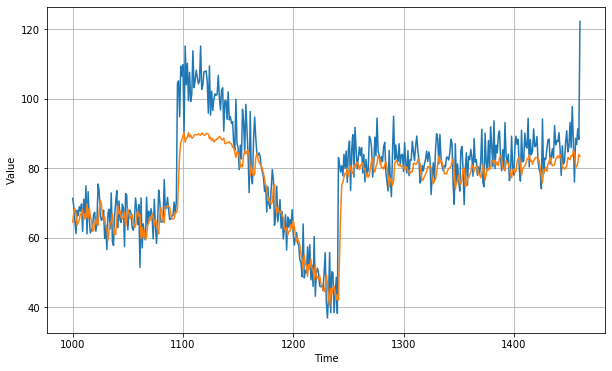

In [9]:
#Depois de treinado, posso usá-lo para prever o intervalo de validação e representar graficamente os resultados.
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
#Não é tão ruim esse valor mas é ruim. Pode-se ver que uma parte do grafico está desigual
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.080576

<Figure size 432x288 with 0 Axes>

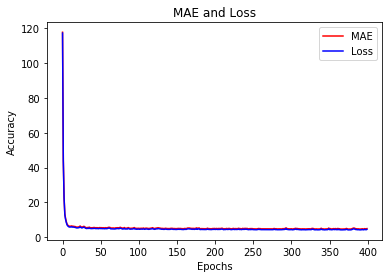

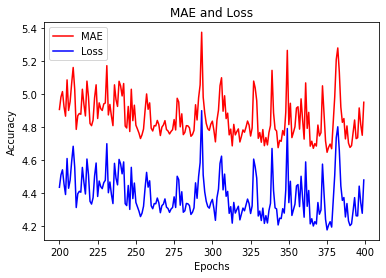

<Figure size 432x288 with 0 Axes>

In [11]:
#MAE e a perda de treinamento
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()